In [240]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('..')
from src import soporte_temporales as st
from src import soporte_sarima as ss

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
df_accidentes = pd.read_csv('..//Datos//datos_accidentes//datos_accidentes_seriet.csv')
df_defunciones = pd.read_csv('..//Datos//datos_defunciones//datos_defunciones_seriet.csv')
df_autos_historicos = pd.read_csv('..//Datos//datos_parquev//parquev_historico.csv')
df_poblacion = pd.read_csv('../Datos/Datos_poblacion.csv', index_col=0)

# Accidentes

In [242]:
df_accidentes.head()

,FECHA,Accidentes
0,2007-01-01,138
1,2007-02-01,125
2,2007-03-01,134
3,2007-04-01,130
4,2007-05-01,108


In [243]:
# instanciamos la clase
analisis_st = ss.TimeSeriesAnalysis(df_accidentes, temporal_column="FECHA", value_column="Accidentes")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 1

----------

En este conjunto de datos tenemos 126 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Accidentes,204,139,22,71,125,138,151,195


In [244]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


In [245]:
analisis_st.graficar_serie()

In [246]:
analisis_st.graficar_media_movil(window=12)

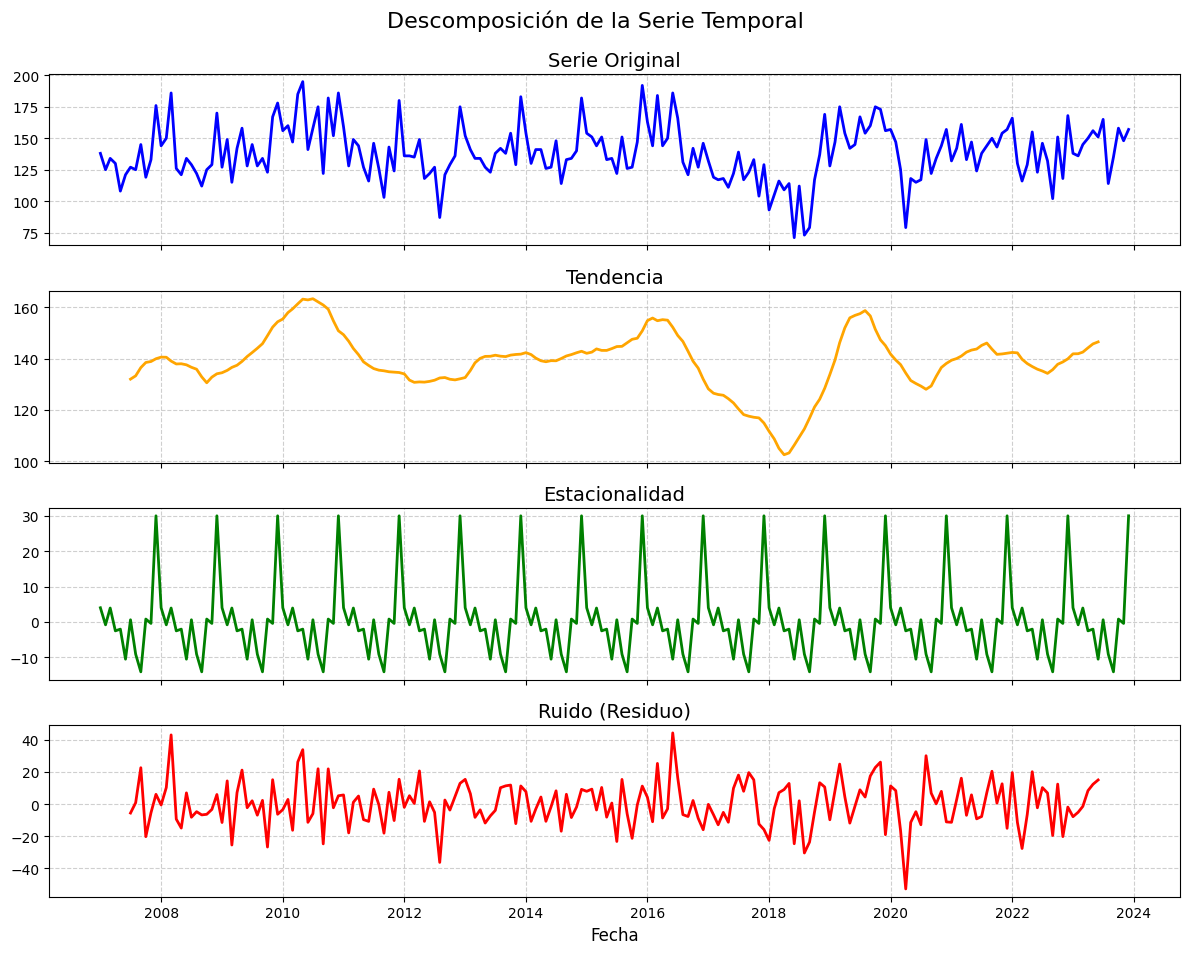

In [247]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

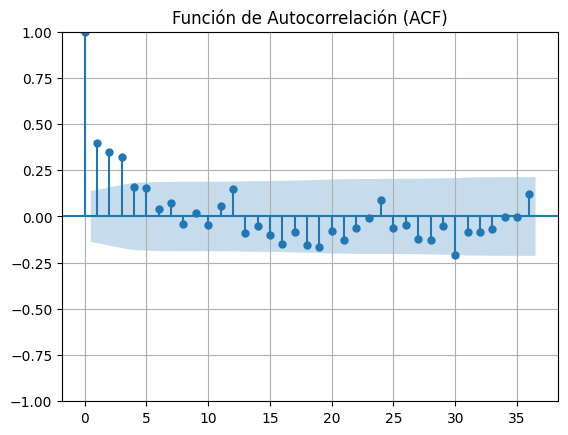

<Figure size 1200x1000 with 0 Axes>

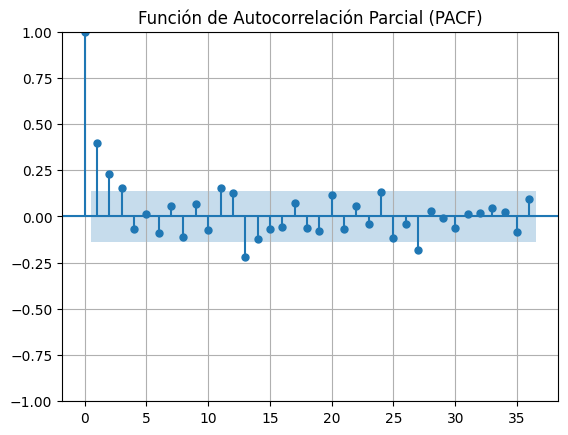

In [248]:
analisis_st.graficar_acf_pacf(lags=36)

In [249]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6373384481895483
p-value: 0.00508603462364682
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


Sarima

In [250]:
df_accidentes.set_index('FECHA', inplace=True)

In [251]:
df_accidentes.head()

,Accidentes
FECHA,
2007-01-01,138
2007-02-01,125
2007-03-01,134
2007-04-01,130
2007-05-01,108


In [252]:
train_size = int(0.7 * len(df_accidentes))
y_train, y_test = df_accidentes[:train_size], df_accidentes[train_size:]

In [253]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

  0%|          | 0/160 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodel

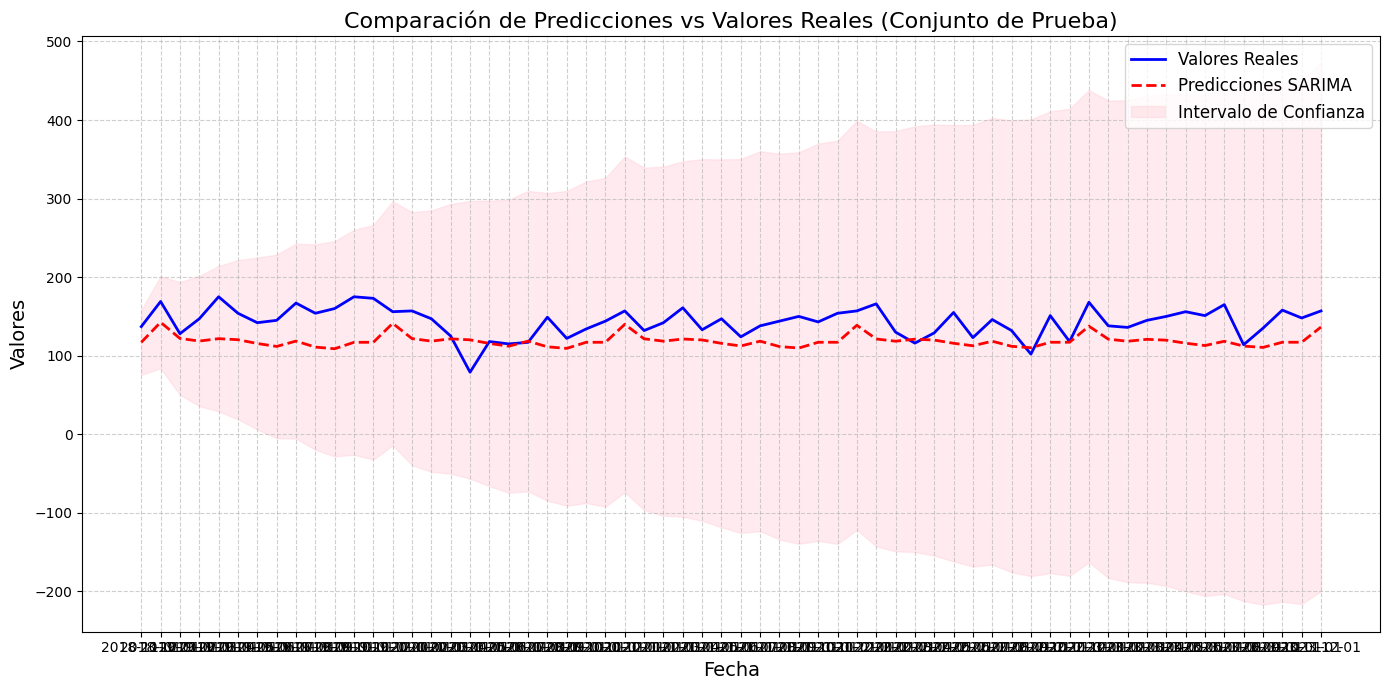

In [254]:
# Evaluar modelos
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_accidentes), variable="Accidentes")

In [255]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",32
7,0,0,"(1, 1, 1, 12)",33
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",35


In [256]:
modelo_sarima= SARIMAX(df_accidentes, 
                    order= (3,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_accidentes), end=len(df_accidentes)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [257]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de accidentes de vehículos en República Dominicana')

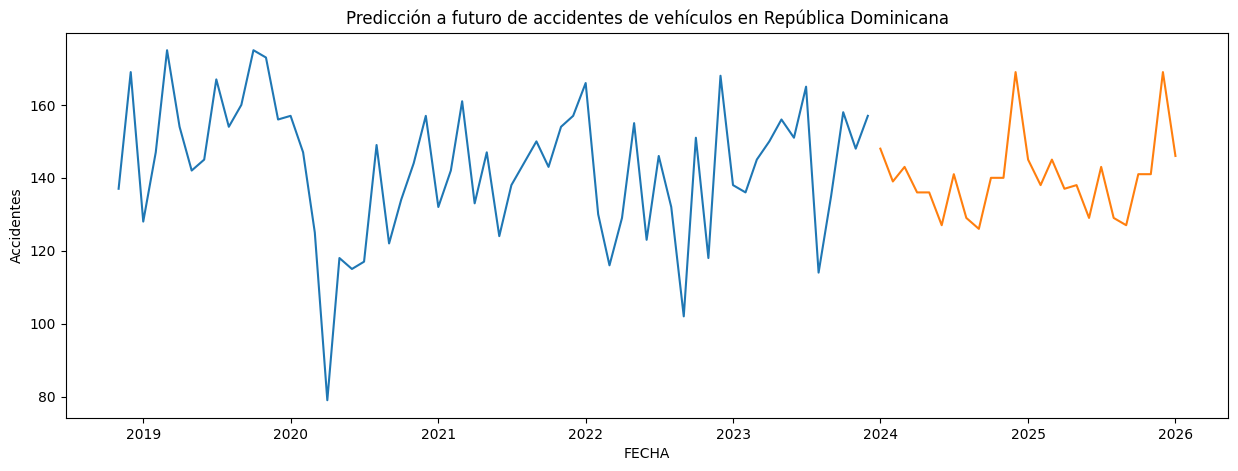

In [258]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Accidentes', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de accidentes de vehículos en República Dominicana')

# Defunciones

In [259]:
df_defunciones.head()

,FECHA,Defunciones
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


In [260]:
df_copia = df_defunciones.copy()
df_copia['FECHA'] = pd.to_datetime(df_copia['FECHA'])
df_copia["Month"] = df_copia["FECHA"].dt.month_name()
df_copia["Year"] = df_copia["FECHA"].dt.year
df_copia.head()

,FECHA,Defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [261]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="FECHA", value_column="Defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [262]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [263]:
analisis_st.graficar_serie()

In [264]:
analisis_st.graficar_media_movil(window=12)

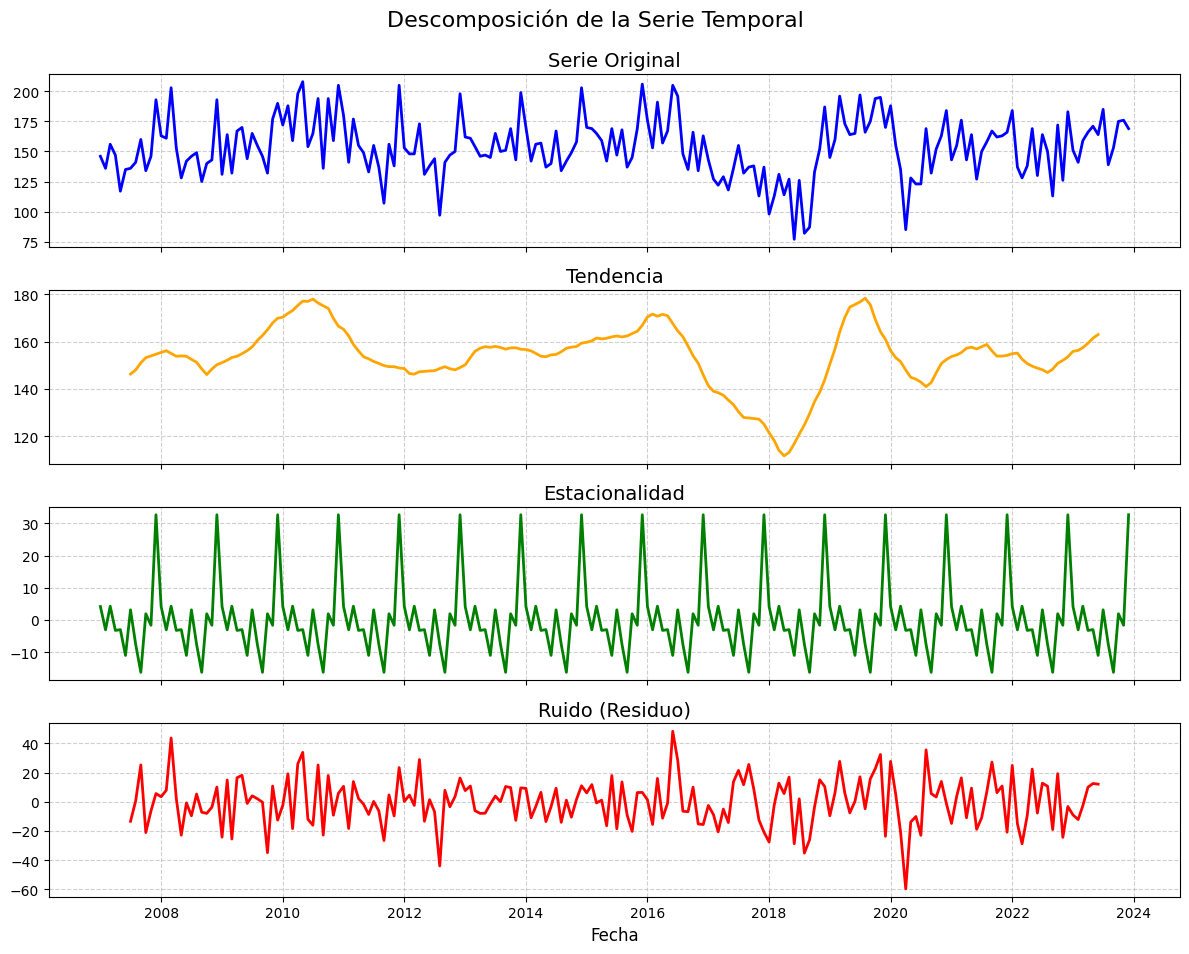

In [265]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

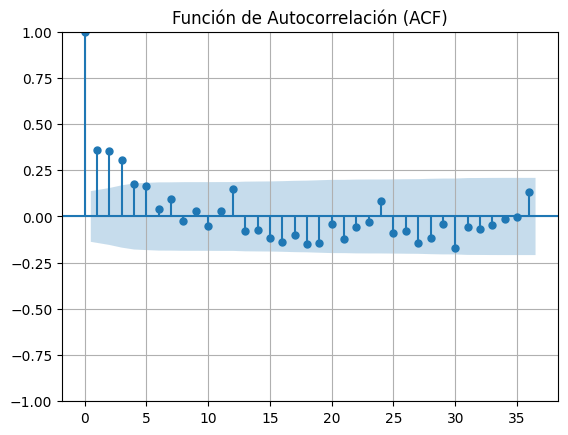

<Figure size 1200x1000 with 0 Axes>

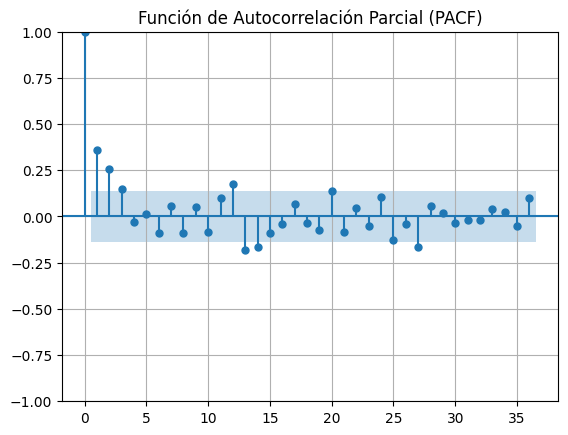

In [266]:
analisis_st.graficar_acf_pacf(lags=36)

In [267]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


In [268]:
df_defunciones.set_index('FECHA', inplace=True)

In [269]:
train_size = int(0.7 * len(df_defunciones))
y_train, y_test = df_defunciones[:train_size], df_defunciones[train_size:]

In [270]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

  0%|          | 0/160 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodel

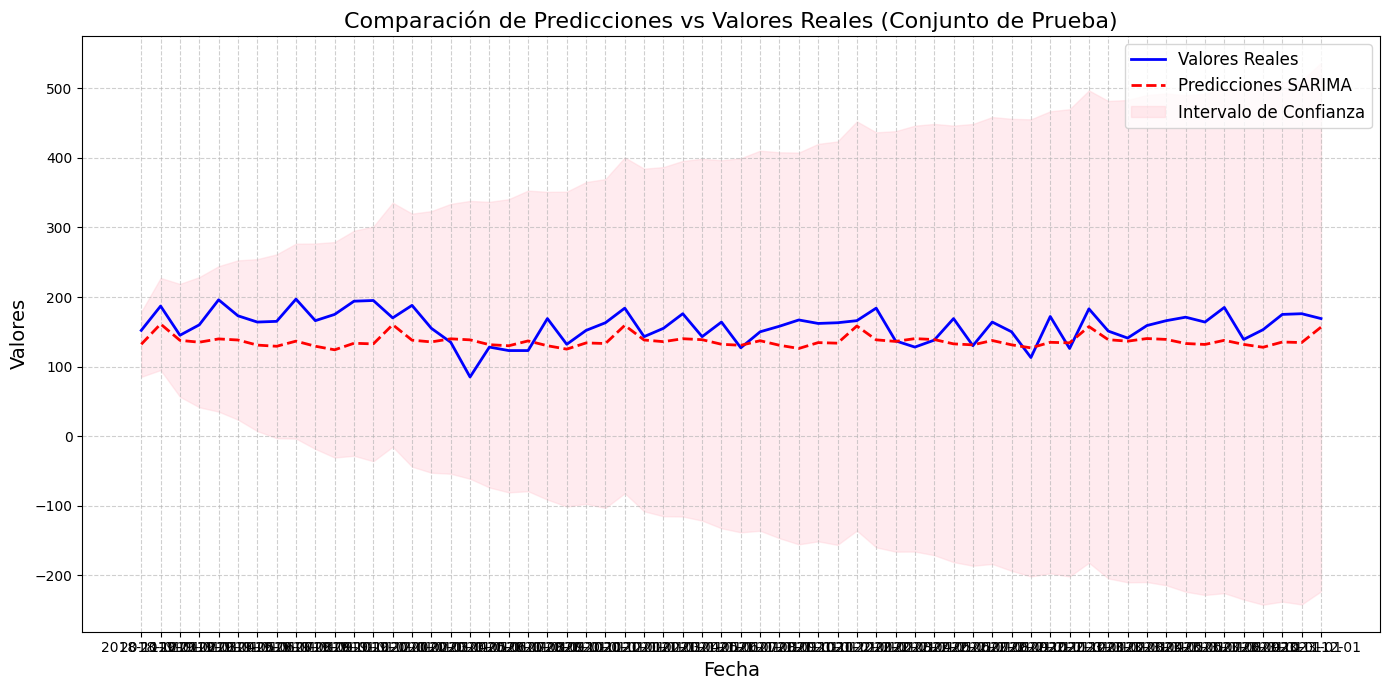

In [271]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_defunciones), variable="Defunciones")

In [272]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",33
7,0,0,"(1, 1, 1, 12)",34
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",34


In [273]:
modelo_sarima= SARIMAX(df_defunciones, 
                    order= (3,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_defunciones), end=len(df_defunciones)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sari

In [274]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

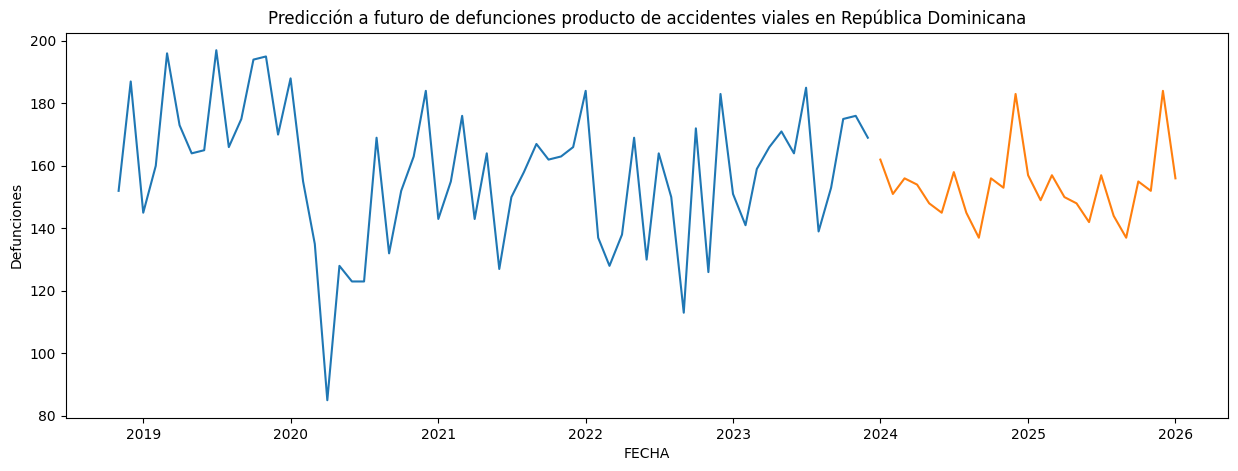

In [276]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Defunciones', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

# Parque Vehicular

In [298]:
df_autos_historicos.head()

,Unnamed: 0,Total
0,1998,936083
1,1999,1090833
2,2000,1294998
3,2001,1436165
4,2002,1611023


In [299]:
df_autos_historicos.columns = ['FECHA', 'Vehículos']
df_autos_historicos['FECHA'] = pd.to_datetime(df_autos_historicos['FECHA'].astype(str) + '-12-01')

In [300]:
df_autos_historicos.head()

,FECHA,Vehículos
0,1998-12-01,936083
1,1999-12-01,1090833
2,2000-12-01,1294998
3,2001-12-01,1436165
4,2002-12-01,1611023


In [301]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_autos_historicos, temporal_column="FECHA", value_column="Vehículos")

analisis_st.exploracion_datos()

El número de filas es 27 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Vehículos,27,3118597,1526266,936083,1823660,2917573,4224111,6160988


In [302]:
analisis_st.comprobar_serie_continua(freq='A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [303]:
analisis_st.graficar_serie()

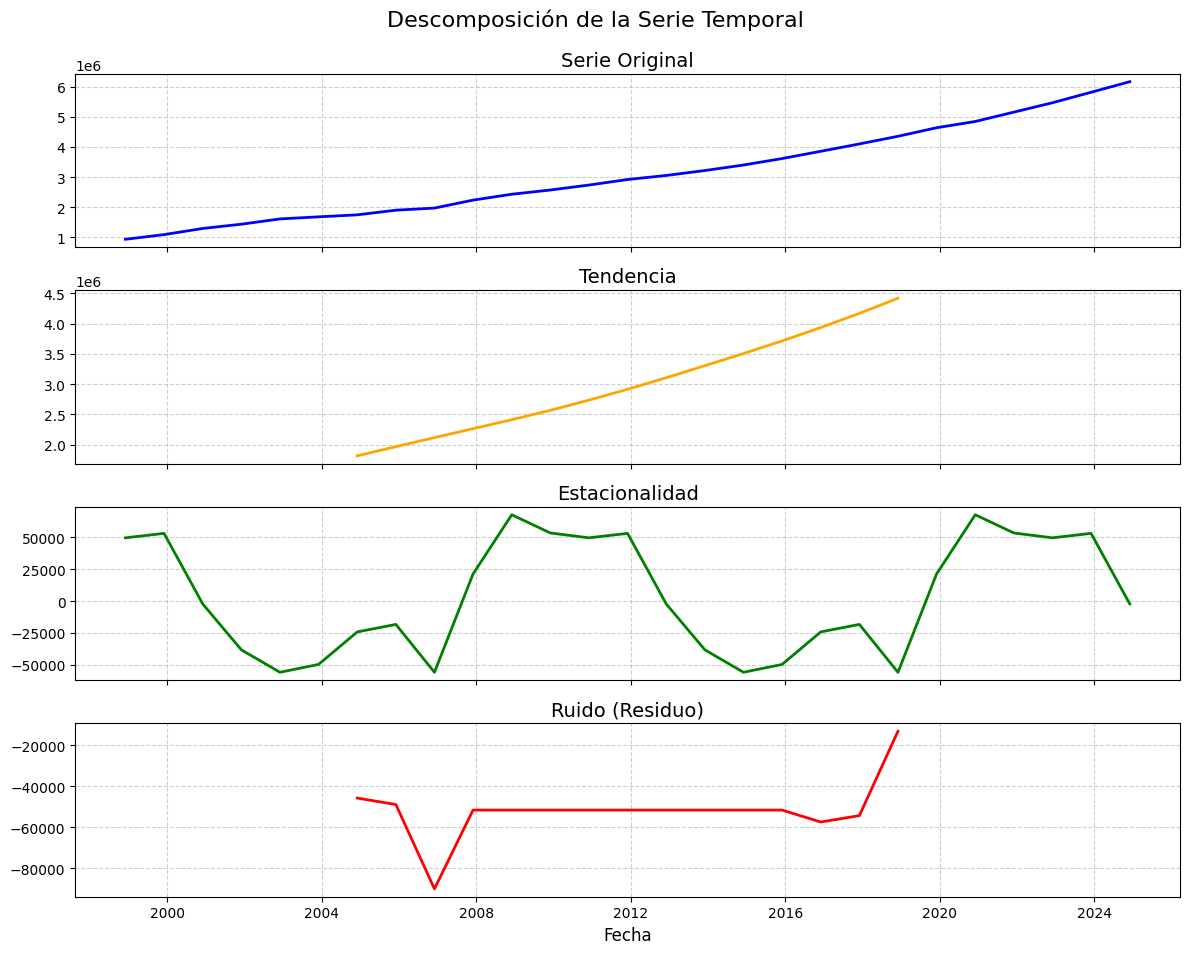

In [304]:
analisis_st.detectar_estacionalidad()

In [305]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 6.443519495590372
p-value: 1.0
Valores Críticos:
1%: -3.7112123008648155
5%: -2.981246804733728
10%: -2.6300945562130176
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


ARIMA

In [306]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [307]:
train_size= int(0.7 * len(df_autos_historicos))
df_autos_historicos.set_index('FECHA', inplace=True)
df_autos_historicos.index = pd.to_datetime(df_autos_historicos.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_autos_historicos[:train_size], df_autos_historicos[train_size:]

In [309]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

,p,q,RMSE
0,1,1,632687
1,1,2,633129
2,1,3,637013


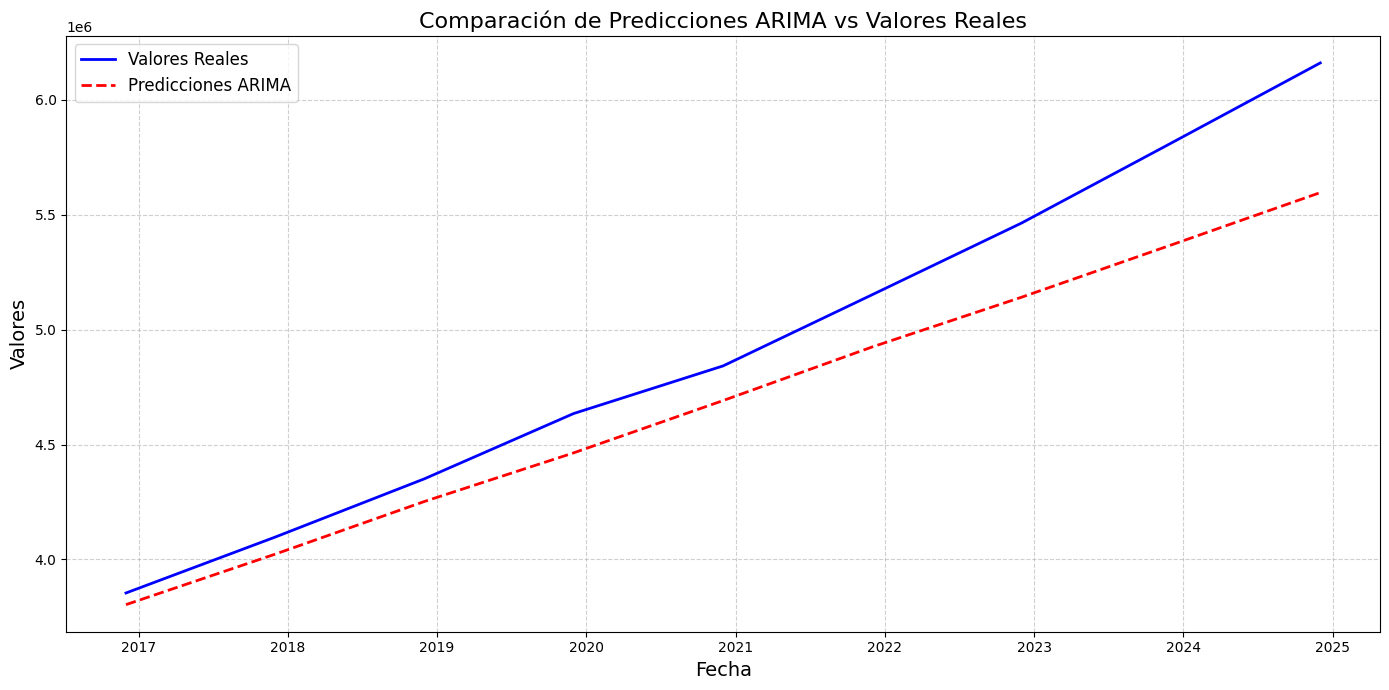

In [310]:
modelo_arima.visualizar_predicciones(y_test)

# Población

In [312]:
df_poblacion.head()

,ANOOCU,Población
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [313]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-01')

In [315]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [316]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [317]:
analisis_st.graficar_serie()

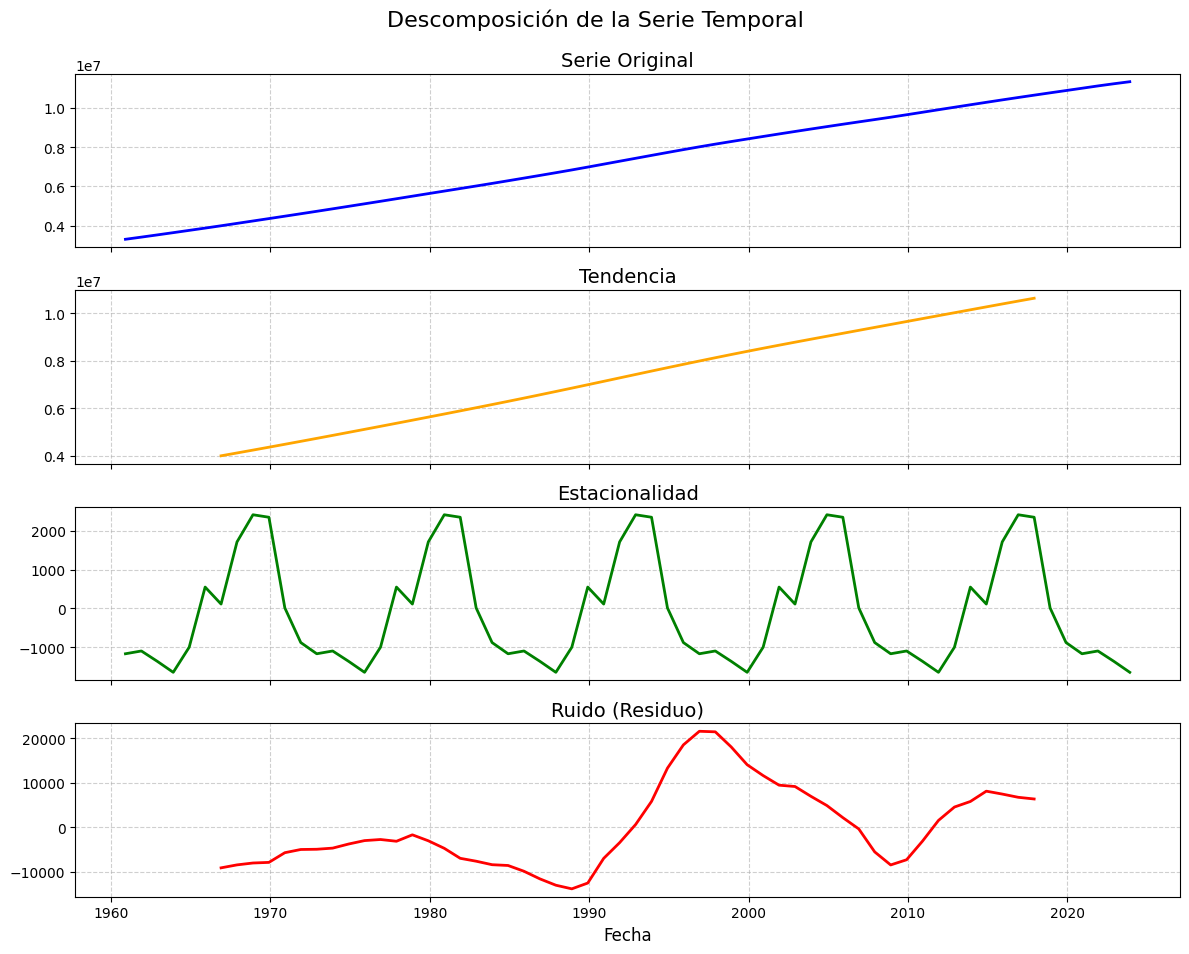

In [319]:
analisis_st.detectar_estacionalidad()

In [320]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [324]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [325]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [326]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

,p,q,RMSE
0,1,1,95902
1,1,2,99603
2,1,3,4155560


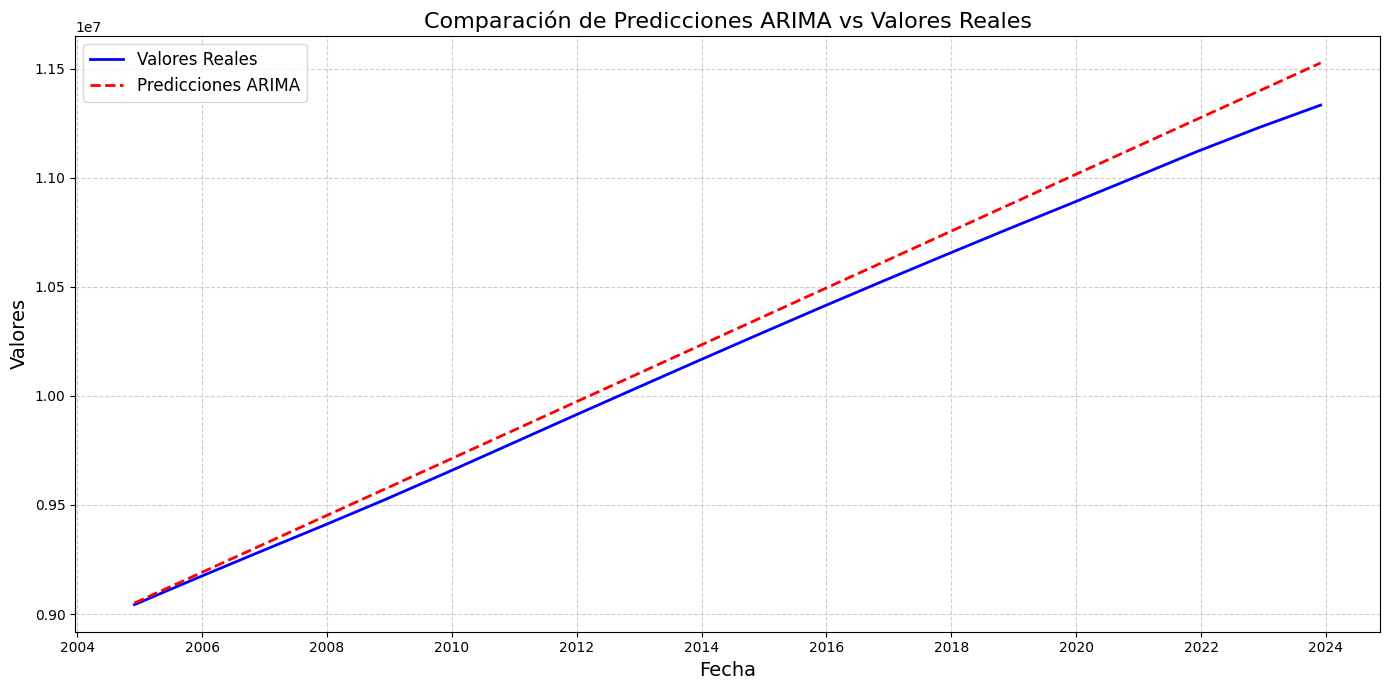

In [327]:
modelo_arima.visualizar_predicciones(y_test)

In [329]:
df_poblacion.reset_index(inplace=True)
df_poblacion.columns = ['ds', 'y']

ARIMA

In [330]:
df_poblacion.head()

,ds,y
0,1960-12-01,3298021
1,1961-12-01,3408415
2,1962-12-01,3521164
3,1963-12-01,3635798
4,1964-12-01,3752313


In [331]:
df_poblacion.tail()

,ds,y
59,2019-12-01,10881882
60,2020-12-01,10999664
61,2021-12-01,11117873
62,2022-12-01,11228821
63,2023-12-01,11332972


In [335]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=1096) 
m.predict(future)

23:49:47 - cmdstanpy - INFO - Chain [1] start processing
23:49:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-01,207290,3289349,3302663,207290,207290,3089158,3089158,3089158,3089158,3089158,3089158,0,0,0,3296449
1,1961-12-01,321163,3402676,3415571,321163,321163,3087995,3087995,3087995,3087995,3087995,3087995,0,0,0,3409157
2,1962-12-01,435035,3515295,3528768,435035,435035,3086864,3086864,3086864,3086864,3086864,3086864,0,0,0,3521899
3,1963-12-01,548938,3628975,3642662,548938,548938,3086468,3086468,3086468,3086468,3086468,3086468,0,0,0,3635406
4,1964-12-01,663153,3745440,3758939,663153,663153,3089158,3089158,3089158,3089158,3089158,3089158,0,0,0,3752311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,2026-11-27,8630557,12244825,12266741,8621701,8639044,3624995,3624995,3624995,3624995,3624995,3624995,0,0,0,12255552
1156,2026-11-28,8630887,11946151,11967977,8622021,8639386,3325710,3325710,3325710,3325710,3325710,3325710,0,0,0,11956597
1157,2026-11-29,8631217,11782956,11804956,8622341,8639729,3162313,3162313,3162313,3162313,3162313,3162313,0,0,0,11793529
1158,2026-11-30,8631546,11717425,11738629,8622660,8640072,3096662,3096662,3096662,3096662,3096662,3096662,0,0,0,11728209


In [337]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1155,2026-11-27,12255552,12244449,12267600
1156,2026-11-28,11956597,11945086,11968600
1157,2026-11-29,11793529,11782162,11805080
1158,2026-11-30,11728209,11716818,11740070
1159,2026-12-01,11718740,11706793,11729670


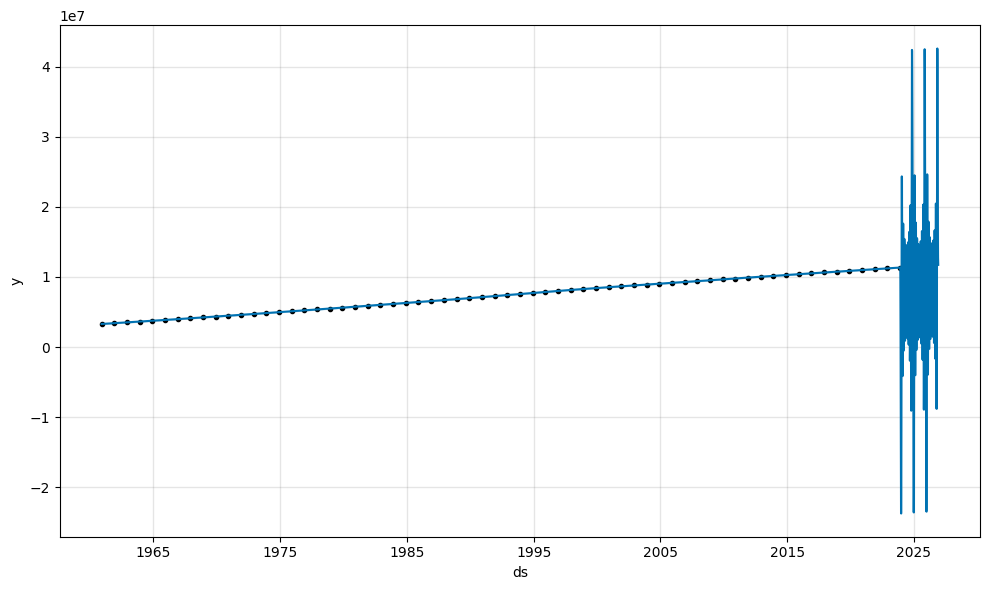

In [338]:
fig1 = m.plot(forecast)

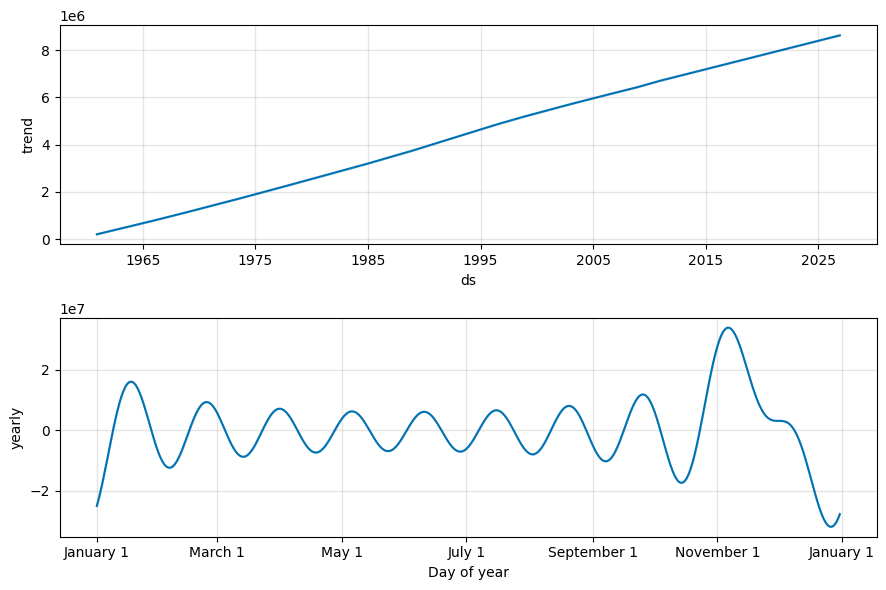

In [339]:
fig2 = m.plot_components(forecast)

In [340]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [341]:
plot_components_plotly(m, forecast)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [336]:
df_poblacion

,ds,y
0,1960-12-01,3298021
1,1961-12-01,3408415
2,1962-12-01,3521164
3,1963-12-01,3635798
4,1964-12-01,3752313
...,...,...
59,2019-12-01,10881882
60,2020-12-01,10999664
61,2021-12-01,11117873
62,2022-12-01,11228821
